# Introduction Bayesian Methods

**Author: Simon Haxby**

This module is meant to provide a practical, minimal introduction to Bayesian inference and modeling. I assume that one already has exposure to basic frequentists concepts for estimation and hypothesis testing, i.e: MLEs, CIs, p-values etc.

Disclaimer: Don't actually use this as a learning resource. If you intend to learn Bayesian methods use one of the many sources listed in Source.ipynb; I'm just doing this to improve my own understanding.

1. Posteriors
2. Estimation
3. Decision Theory
4. Model Selection/Averaging

## Posteriors
For Bayesian the primary construction in inference and testing is the posterior which is derived using Bayes' Rule. 

$$P(\theta|X) = \frac{P(X|\theta)P(\theta)}{\int_\theta P(X|\theta)P(\theta)d\theta} $$

Here $X$ represents our observations and $\theta$ is a parameter of interest; usually related to the distribution that is used to model $X$. Here $P(\theta)$ is our prior distribution over $\theta$; which is to say we can account for prior beliefs about $\theta$ into our model of $\theta$ after having observed our data $X$.

One of the alluring features of Bayesian methods is that most techniques are simple applications of the posterior distribution of $\theta$. Infering the optimal estimator of $\theta$, predicting new data, selecting models or hypothesis all fall under this characterization.

For example:

1. New data prediction:

    $$P(x\ |X) = \int_\theta P(x\ |X, \theta)\color{Red}{P(\theta|X)}d\theta$$
    
2. Picking optimal estimator, $\hat{\theta}$, by mimizing:

    $$ E_{\theta|X}[L(\theta, \hat{\theta})]= \int_\theta L(\theta, \hat{\theta})\color{Red}{P(\theta|X)}d\theta$$
    
3. Comparing two models:

    $$ \frac{P(M_1 |X)}{P(M_2 |X)} = \frac{P(M_1)\int_{\theta_1} P(M_1 |X, \theta_1)\color{Red}{P(\theta_1|X)}d\theta_1}{P(M_2)\int_{\theta_2} P(M_2 |X, \theta_2)\color{Red}{P(\theta_2|X)}d\theta_2}$$
    
Where $\color{Red}{P(\theta|X)}$ are our posteriors. The examples listed above will be explained in more detail below

## Estimation

Estimating parameters in Bayesian models can be done a number of ways; choice of method can depend on problem tractability, availibility of computational resources and prior information about parameters.

<img src="EstimationTechs.png" alt="Drawing" style="width: 500px;"/>

Our approach lies between MAP and Full Bayes; we will set the prior hyperparameters to constant values but will use the entire posterior to derive point estimates for our model.


In [3]:
import numpy as np
import warnings
from scipy.optimize import minimize
import emcee
import corner
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

Let us examine a regression problem wherein we wish model two continous variables; one in terms of the other. Here underlying relationship between $x$ and $y$ is linear:

$$ y = \theta_1 x + \theta_0 + \epsilon \\
\epsilon \sim \mathcal{N}(0,\ .5x)$$

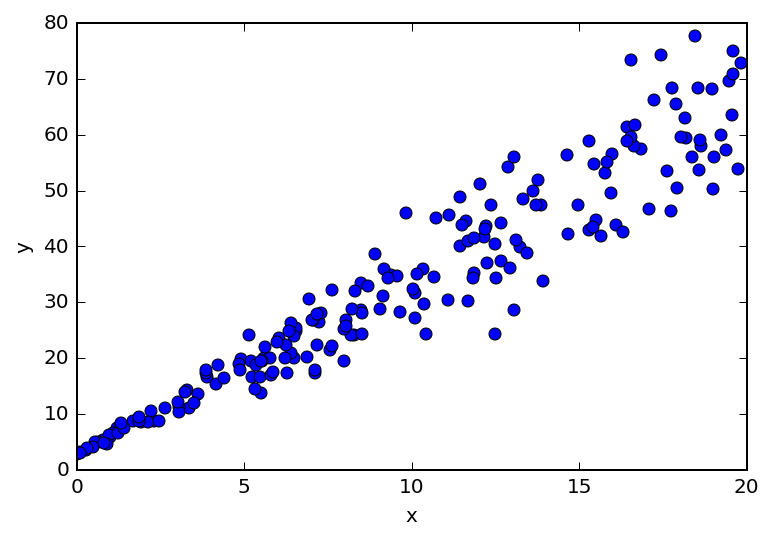

In [4]:
N = 200
m = np.pi
b = np.e

x = np.random.uniform(0,20,N)
y_var = .5*x
epilson = np.random.randn(N)*y_var
y = m*x + b + epilson
plt.plot(x, y, 'bo');
plt.xlabel('x');
plt.ylabel('y');

Without knowing underlying distribution of the data, it is clear $y$ is linear in $x$, and that {$x,y$} are heteroskedastic. It is safe to assume:

$$ y = \theta_1 x + \theta_0 + \epsilon \\
\epsilon \sim \mathcal{N}(0, g(x))$$

If we wish to infer an optimal $ \theta=\{\theta_0, \theta_1\}$; we can do this very simply using Bayesian methods.

Let $X = \{x_i, y_i\}^n_{i=0}$, our observed data. Using Bayes formula we construct a distribution over $\theta$:

$$P(\theta|X) = \frac{P(X|\theta)P(\theta)}{\int_\theta P(X|\theta)P(\theta)d\theta} $$

Using this distribution and a specified loss function, can determine the optimal choice of $\theta$  by minimizing the expected loss with respective the posterior, as shown above.

Using Markov Chain Monte Carlo ([MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)) sampler, we can draw samples from our posterior and then use these samples (in practice a sub-set of these samples) to approximate various functionals of the posterior, such as our loss function. There are caveats of using MCMC methods; computation can be be very involved and time-consuming, and we cannot guarantee that our samples we be charateristic of our posterior.

Below we specify the log of posterior distribution minus the normalization constant $P(X)$.

In [5]:
def lnlike(theta, x, y):
    m, b, y_base, y_hetero = theta
    y_var = y_base + y_hetero*x
    model = m*x+b
    return -.5*np.sum(((model-y)**2/y_var**2) + np.log(2*np.pi*y_var**2)) 

def lnprior(theta):
    m, b, y_base, y_hetero = theta
    if m > 0 and 0 < y_base < 50 and 0 < y_hetero < 1:
        return 0.0
    else:
        return -np.inf

def lnpost(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

Lets run our sampler!

In [6]:
ndim, nwalkers = 4, 100
pos = [1 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=(x, y))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sampler.run_mcmc(pos, 15000);

## Decision Theory

Now we can estimate the optimal estimator using our MCMC samples; here we use a squared loss:

$$ L(\theta, \hat{\theta}) = (\theta - \hat{\theta})^2$$

And we can approximate our expected loss, where $\theta_s$ is our $s^{th}$ MCMC sample:

$$ E_{\theta|X} [L(\theta, \hat{\theta})] \approx \frac{1}{S}\sum^S_{s=1}(\theta_s - \hat{\theta})^2$$

In [20]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
# Burn-in
thetas = samples[-10000:]
thetas_mean = np.mean(samples[-10000:], axis=0)
emp_loss = lambda theta: np.sum((thetas - theta)**2)
res = minimize(emp_loss, np.ones(4), method='BFGS')

In [21]:
# Minimizer of squared loss
res.x 

array([ 3.12504677,  2.7398286 ,  0.0441064 ,  0.51619326])

In [22]:
# Empirical mean
thetas_mean

array([ 3.12504678,  2.7398286 ,  0.04410641,  0.51619327])

They agree! In fact mean of the posterior always minimizes the squared loss function.

Below we can visualize the samples generated from our MCMC sampler.

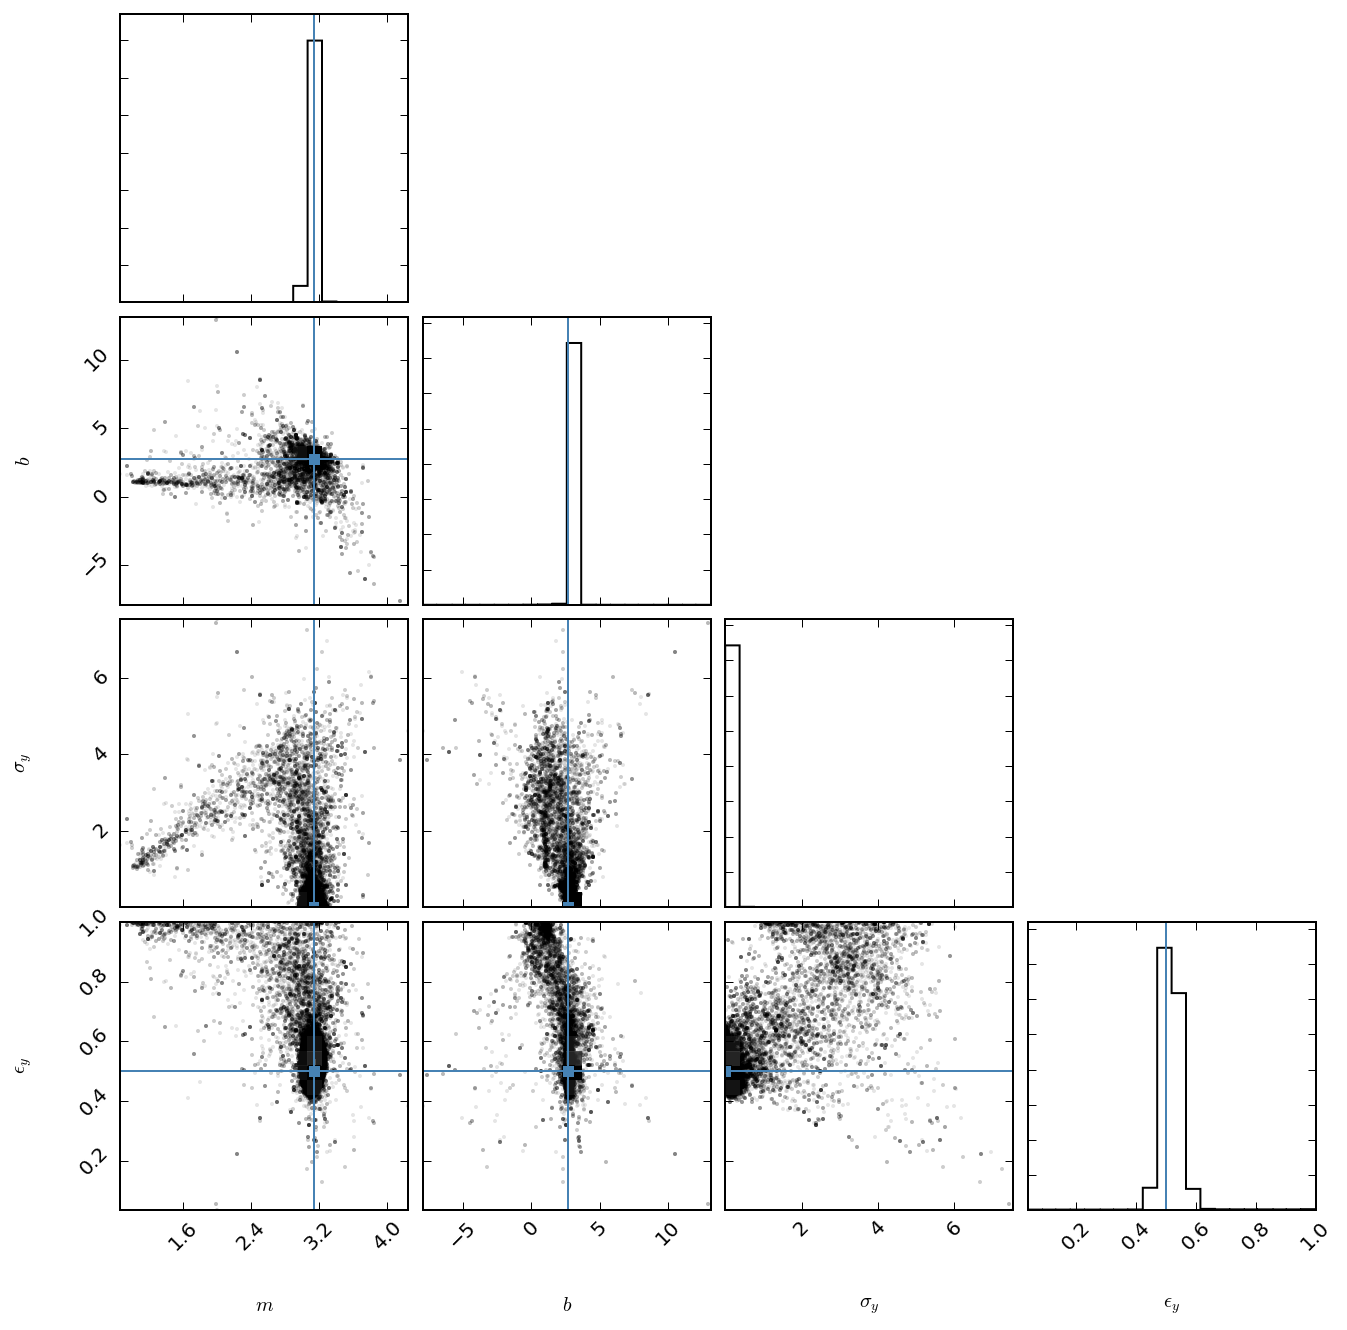

In [23]:
fig = corner.corner(samples, labels=["$m$", "$b$", "$\sigma_y$", "$\epsilon_y$"],
                      truths=[m, b, 0, .5], plot_contours=False)

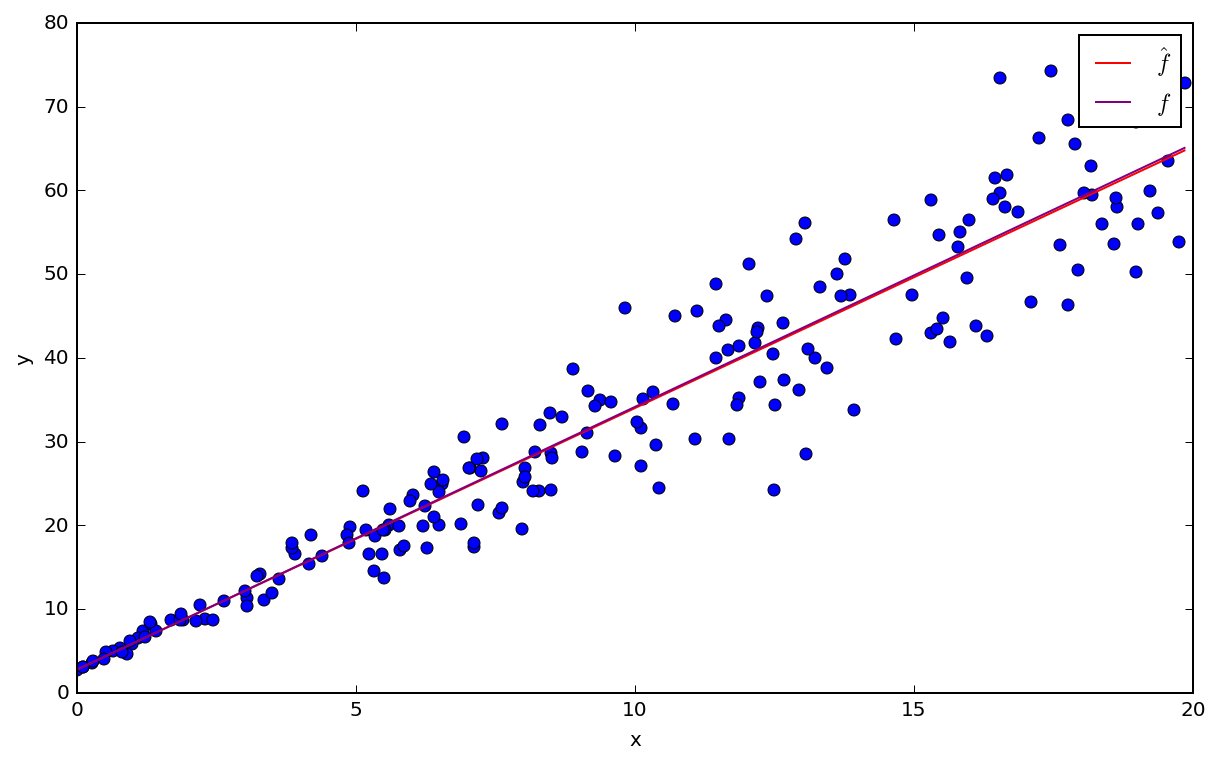

In [24]:
theta_hat = res.x

t = np.linspace(min(x), max(x), 1000)
f_approx = lambda t: theta_hat[0]*t + theta_hat[1]
f = lambda t: m*t + b

plt.figure(figsize=(10,6))
plt.plot(x, y, 'bo');
plt.plot(t, f_approx(t), 'red', label="$\hat{f}$")
plt.plot(t, f(t), 'purple', label = '$f$')
plt.xlabel('x');
plt.ylabel('y');
plt.legend();

Nearly a perfect fit!

## TODO

* Use PyMC for discrete model